In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Thanks to this notebook https://www.kaggle.com/code/lucamassaron/kaggle-merchandise-eda-with-baseline-linear-model/notebook

# Time Series Analysis of Kaggle Store

## Outline

1) Examine the data. How is the data split? Is there seasonal variations and trends? Do there appear to be any holidays?
 
     - Look at country, shop and item levels
 
2) Feature Engineer for Machine Learning Models. Need to transform data into something that models can use.

3) Use linear regression and LGBM model for predicting the future sales of each item type.

## Examine Data

In [2]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/test.csv', parse_dates=['date'])
samp_submission = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv')

In [3]:
samp_submission.head(1)

row_id  num_sold
0   26298       100

In [4]:
train.head()

row_id       date  country       store         product  num_sold
0       0 2015-01-01  Finland  KaggleMart      Kaggle Mug       329
1       1 2015-01-01  Finland  KaggleMart      Kaggle Hat       520
2       2 2015-01-01  Finland  KaggleMart  Kaggle Sticker       146
3       3 2015-01-01  Finland  KaggleRama      Kaggle Mug       572
4       4 2015-01-01  Finland  KaggleRama      Kaggle Hat       911

In [5]:
test.head(2)

row_id       date  country       store     product
0   26298 2019-01-01  Finland  KaggleMart  Kaggle Mug
1   26299 2019-01-01  Finland  KaggleMart  Kaggle Hat

In [6]:
cat_cols = ['country','store','product']

In [7]:
train.dtypes

row_id               int64
date        datetime64[ns]
country             object
store               object
product             object
num_sold             int64
dtype: object

In [8]:
for cat in train[cat_cols]:
    print(train[cat].nunique())

3
2
3


### Are all 18 possible combinations present?

In [9]:
train.groupby(cat_cols).size().reset_index().rename(columns={0:'count'})

country       store         product  count
0   Finland  KaggleMart      Kaggle Hat   1461
1   Finland  KaggleMart      Kaggle Mug   1461
2   Finland  KaggleMart  Kaggle Sticker   1461
3   Finland  KaggleRama      Kaggle Hat   1461
4   Finland  KaggleRama      Kaggle Mug   1461
5   Finland  KaggleRama  Kaggle Sticker   1461
6    Norway  KaggleMart      Kaggle Hat   1461
7    Norway  KaggleMart      Kaggle Mug   1461
8    Norway  KaggleMart  Kaggle Sticker   1461
9    Norway  KaggleRama      Kaggle Hat   1461
10   Norway  KaggleRama      Kaggle Mug   1461
11   Norway  KaggleRama  Kaggle Sticker   1461
12   Sweden  KaggleMart      Kaggle Hat   1461
13   Sweden  KaggleMart      Kaggle Mug   1461
14   Sweden  KaggleMart  Kaggle Sticker   1461
15   Sweden  KaggleRama      Kaggle Hat   1461
16   Sweden  KaggleRama      Kaggle Mug   1461
17   Sweden  KaggleRama  Kaggle Sticker   1461

### All are present and in equal distributions

In [10]:
train_dates = train.date.drop_duplicates().sort_values()
test_dates = test.date.drop_duplicates().sort_values()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 0.75)

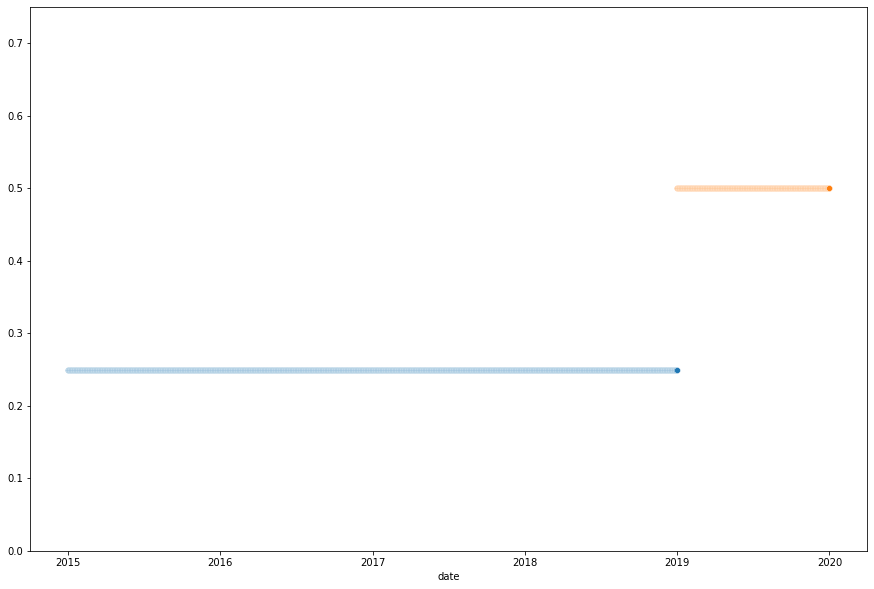

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(train_dates, x='train_dates',y=0.25)
sns.scatterplot(test_dates, x='test_dates',y=0.5)
plt.ylim(top=0.75, bottom=0)

# Basic Feature Engineering

* Future ideas could include adding a sin/cos component to better capture the cyclic purchase pattern
* Manually add in holiday details for each sale region, as the items are holiday related purchases
* Add economic data for each region to see if this has a correlation with items sold

In [12]:
def process_time(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week.astype("int64")
    #df['week'][df['week']>52] = 52
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    return df

train = process_time(train)
test = process_time(test)

In [13]:
train.dtypes

row_id                int64
date         datetime64[ns]
country              object
store                object
product              object
num_sold              int64
year                  int64
month                 int64
week                  int64
day                   int64
dayofweek             int64
quarter               int64
dayofyear             int64
dtype: object

In [14]:
train.head(2)

row_id       date  country       store     product  num_sold  year  month  \
0       0 2015-01-01  Finland  KaggleMart  Kaggle Mug       329  2015      1   
1       1 2015-01-01  Finland  KaggleMart  Kaggle Hat       520  2015      1   

   week  day  dayofweek  quarter  dayofyear  
0     1    1          3        1          1  
1     1    1          3        1          1

# Notes:
- Should generate a graph for each combination
- At the end see which product combination performs the worst

Different ways to visualize the data

In [15]:

# for product in ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']:
#     print(f"\n--- {product} ---\n")
#     fig = plt.figure(figsize=(20, 10), dpi=100)
#     fig.subplots_adjust(hspace=0.25)
#     for i, store in enumerate(['KaggleMart', 'KaggleRama']):
#         for j, country in enumerate(['Finland', 'Norway', 'Sweden']):
#             ax = fig.add_subplot(2, 3, (i*3+j+1))
#             selection = (train['country']==country)&(train['store']==store)&(train['product']==product)
#             selected = train[selection]
#             selected.set_index('date').groupby('year')['num_sold'].mean().plot(ax=ax)
#             ax.set_title(f"{country}:{store}")
#     plt.show()

The despine parameter is set to False so that the borders of the subplots are visible. The margin_titles parameter is set to True so that the titles of the rows and columns appear on the margins of the grid.

g.set_titles(col_template = '{col_name}', row_template = '{row_name}') uses the col_name and row_name as the title of each subplot.

g.set_axis_labels("", "Number of products sold") will set x and y axis label as provided.

g.add_legend(title = 'Product') will add legend for the hue variable 'product'

g.fig.subplots_adjust(hspace=.3) will increase the spacing between subplots by 0.3. You can change the value as per your requirement.

Note: you need to make sure that 'date' is in datetime format, or else you will get error while plotting.

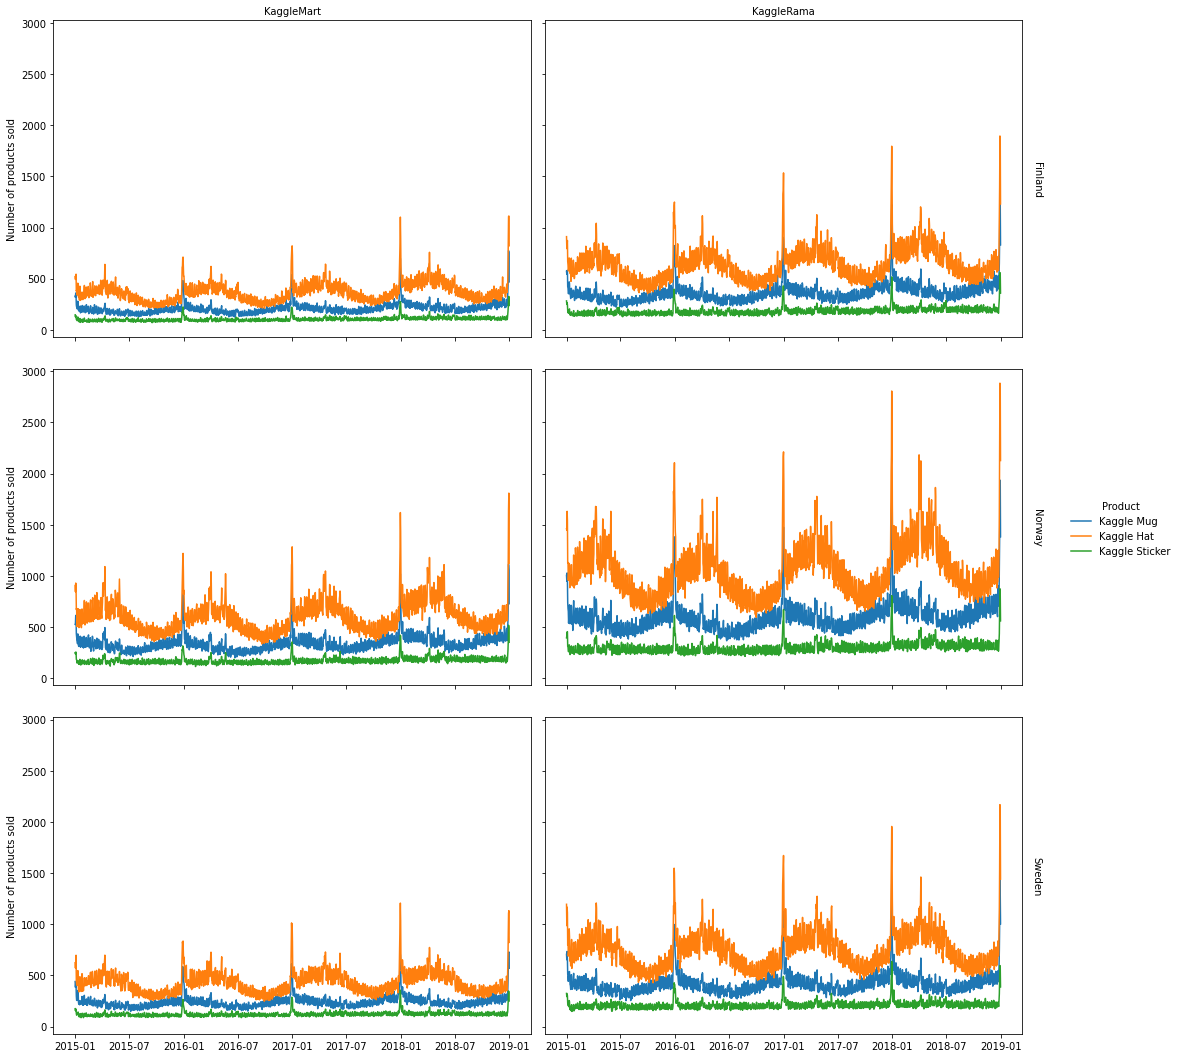

In [16]:
g = sns.FacetGrid(train, col='store', row='country', hue='product', height=5, aspect=1.5, 
                  despine=False, margin_titles=True)
g.map(sns.lineplot, 'date', 'num_sold')
g.set_titles(col_template = '{col_name}', row_template = '{row_name}')
g.set_axis_labels("", "Number of products sold")
g.add_legend(title = 'Product')
g.fig.subplots_adjust(hspace=.1)

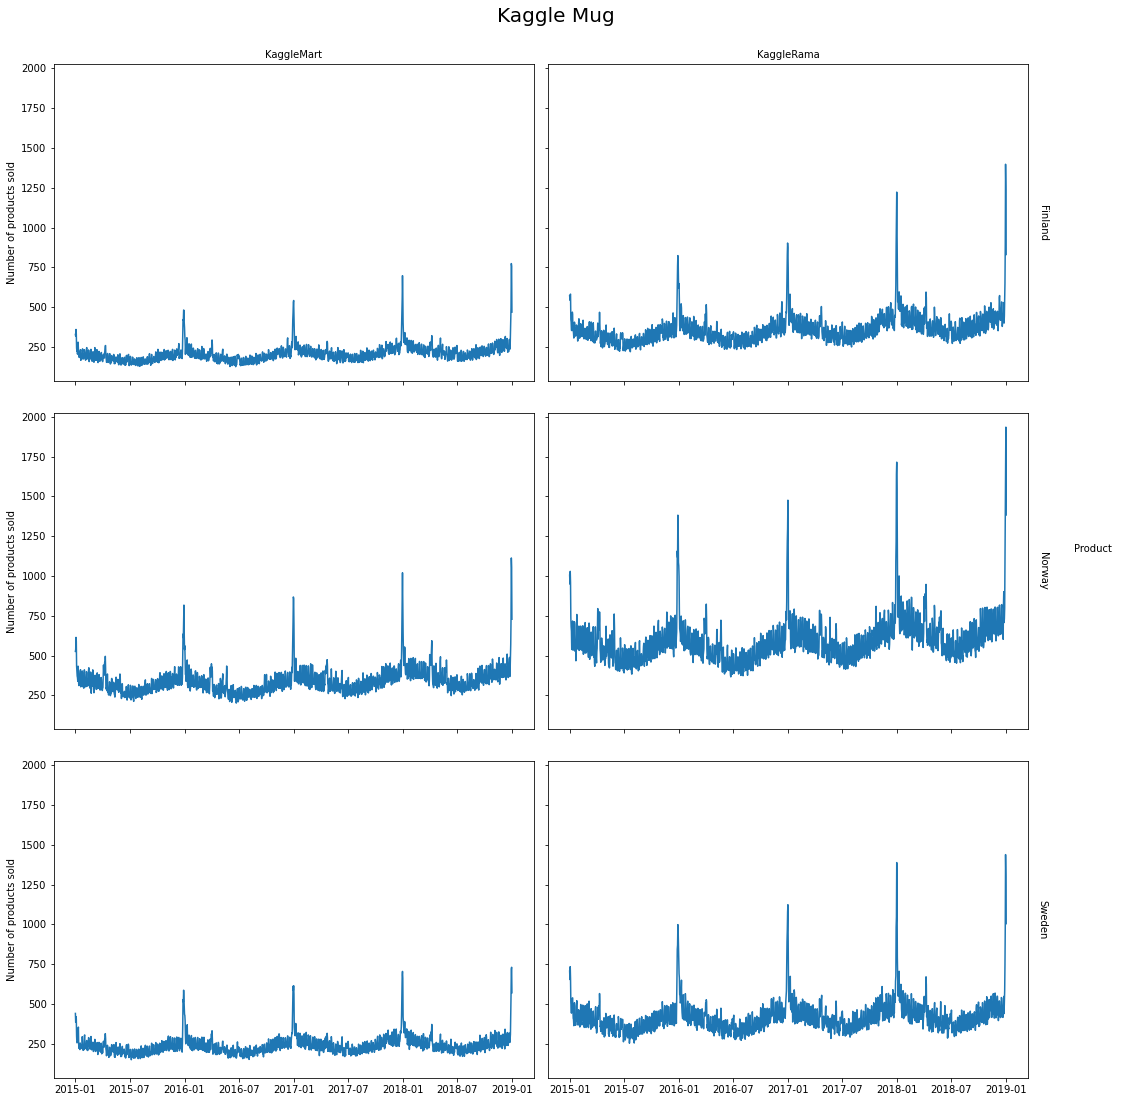

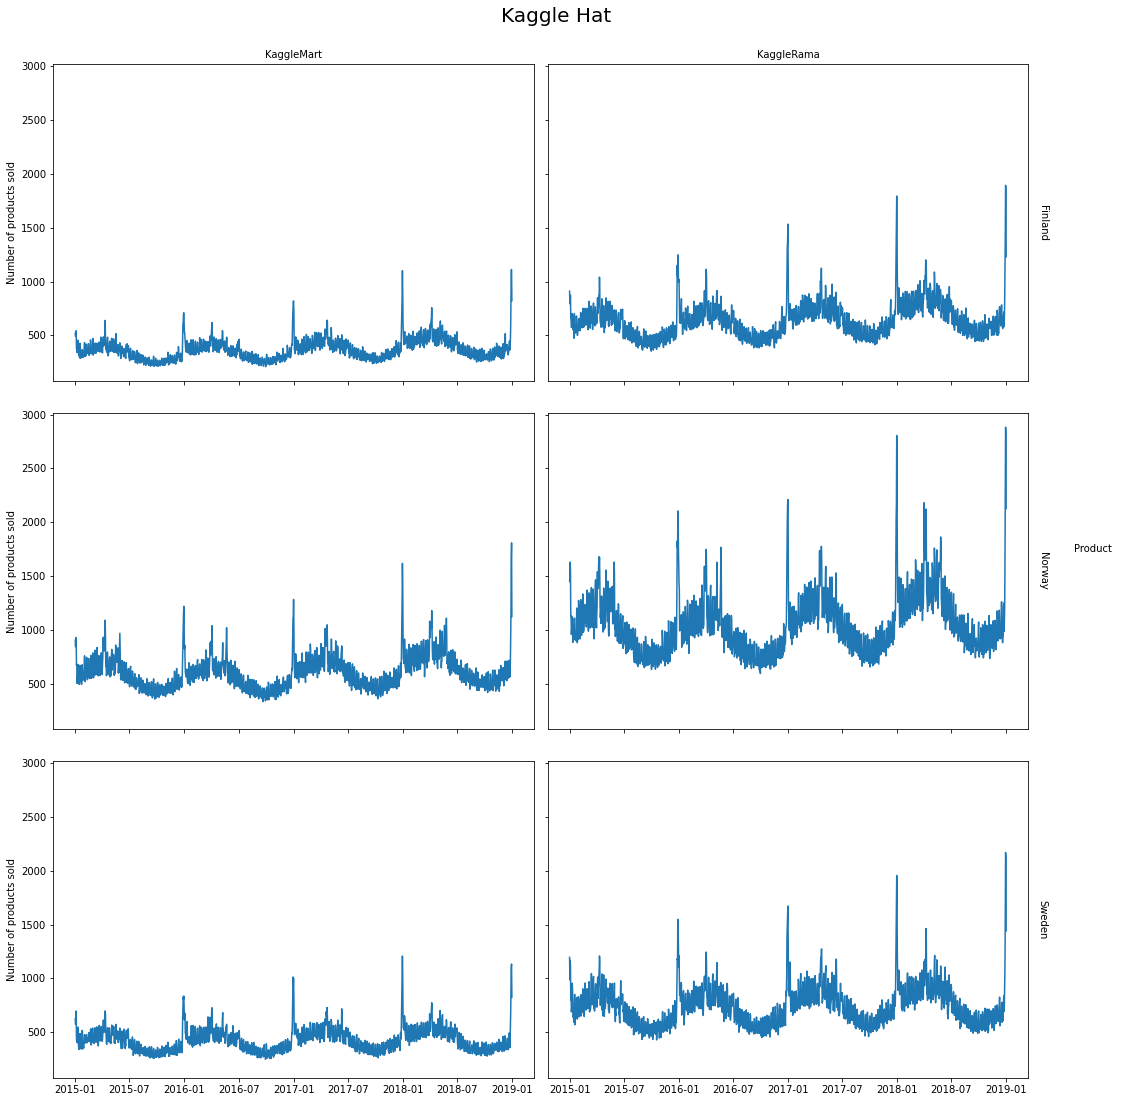

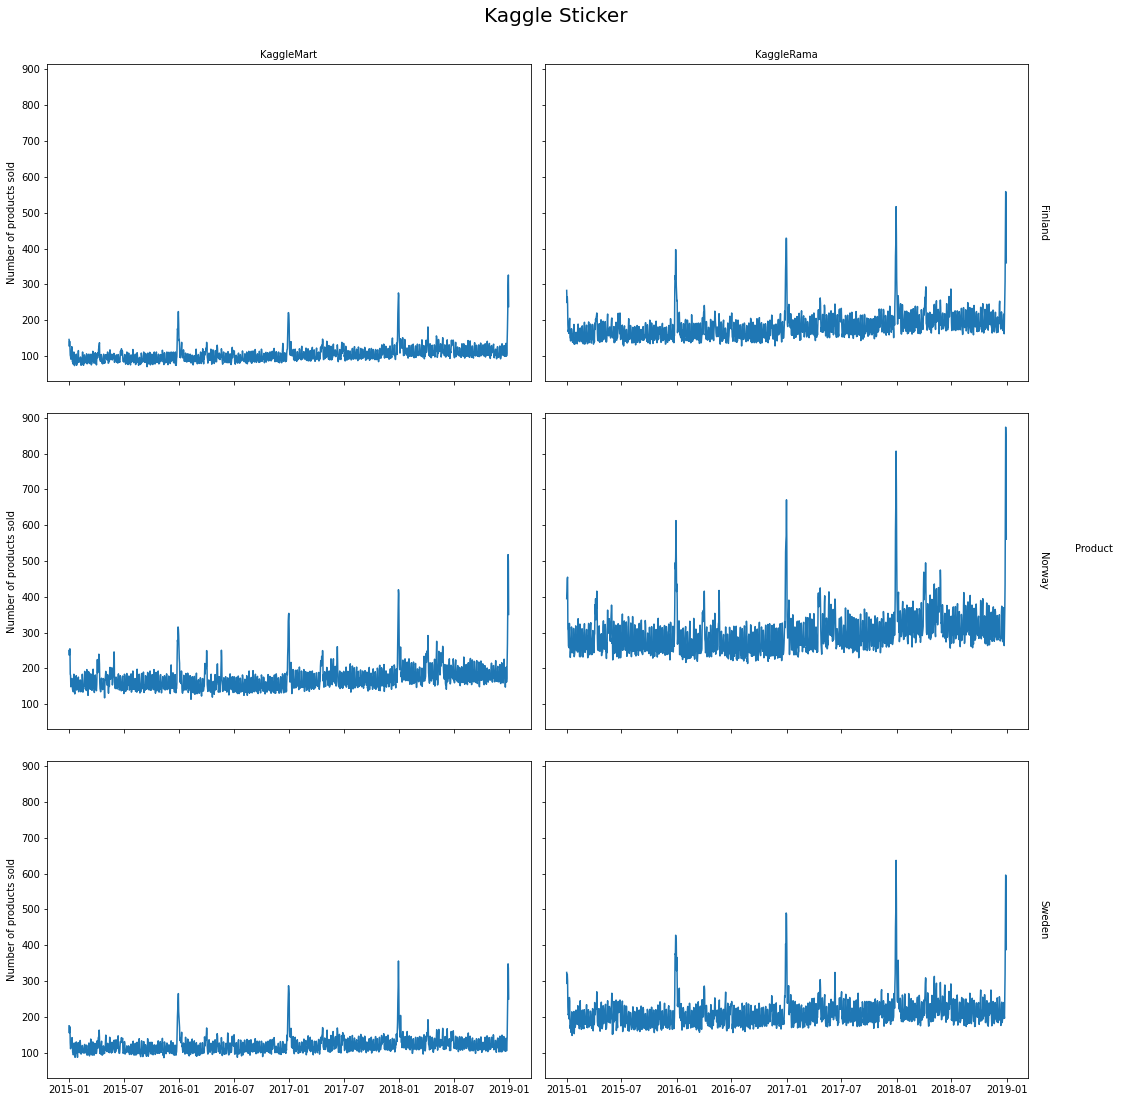

In [17]:
for product in train['product'].unique():
    product_data = train[train['product'] == product]
    g = sns.FacetGrid(product_data, col='store', row='country', height=5, aspect=1.5, despine=False, margin_titles=True)
    g.map(sns.lineplot, 'date', 'num_sold')
    g.set_titles(col_template = '{col_name}', row_template = '{row_name}')
    g.set_axis_labels("", "Number of products sold")
    g.add_legend(title = 'Product')
    g.fig.subplots_adjust(hspace=.1)
    g.fig.suptitle(f"{product}", y = 1.03, fontsize=20)
    plt.show()


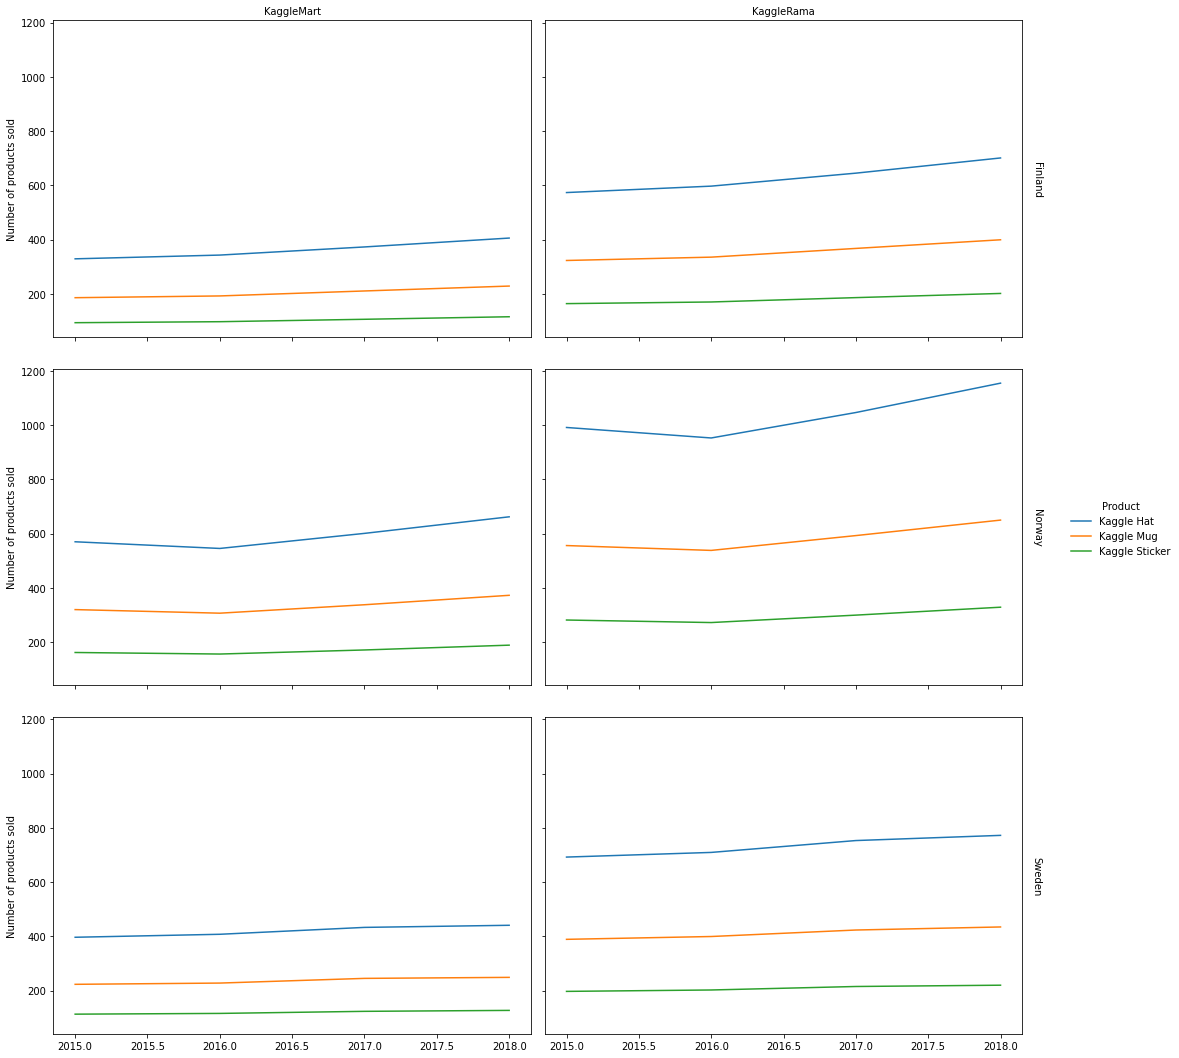

In [18]:
train_copy = train.groupby(['product','store','country','year'])['num_sold'].mean().reset_index()

g = sns.FacetGrid(train_copy, col='store', row='country', hue='product', height=5, aspect=1.5, despine=False, margin_titles=True)
g.map(sns.lineplot, 'year', 'num_sold')
g.set_titles(col_template = '{col_name}', row_template = '{row_name}')
g.set_axis_labels("", "Number of products sold")
g.add_legend(title = 'Product')
g.fig.subplots_adjust(hspace=.1)

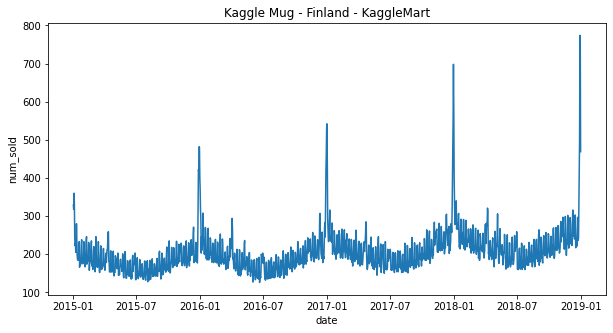

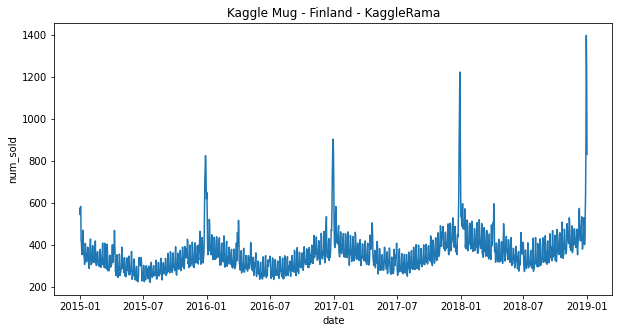

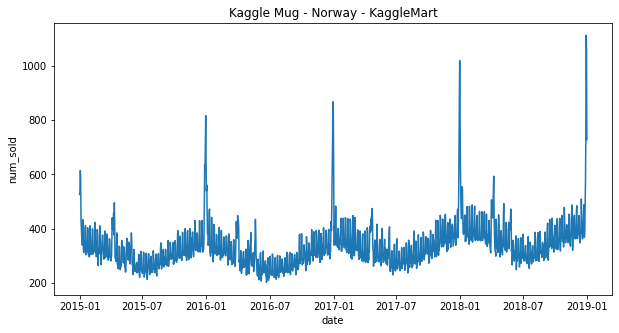

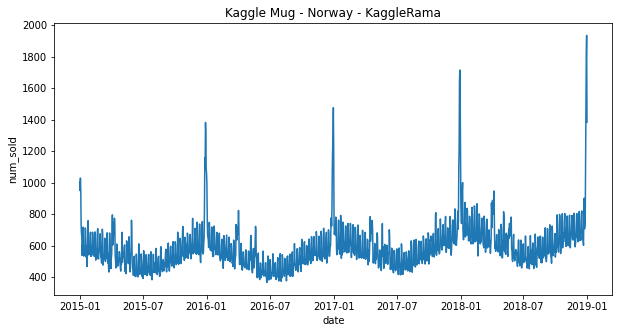

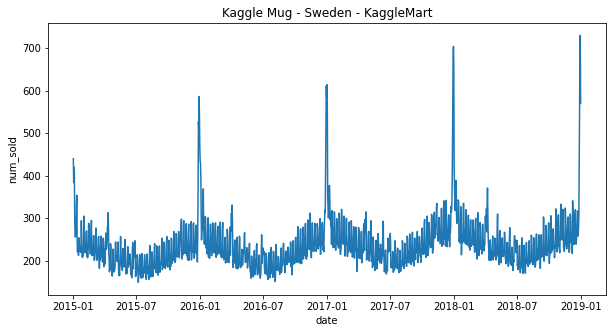

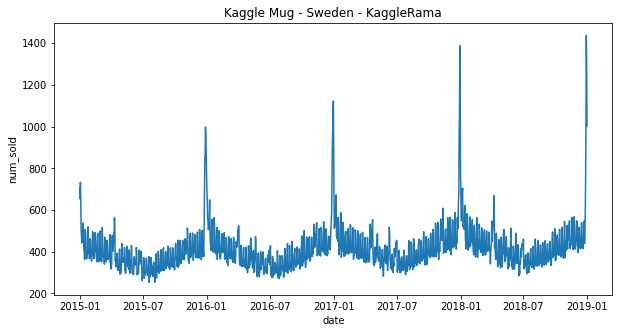

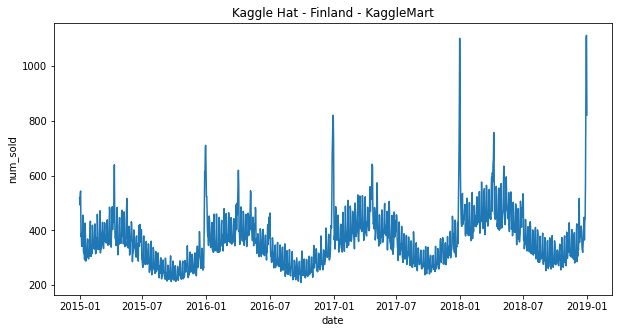

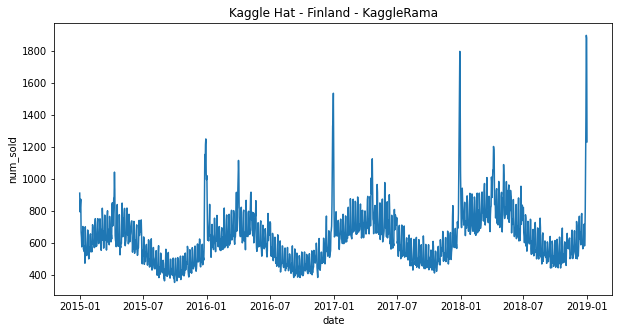

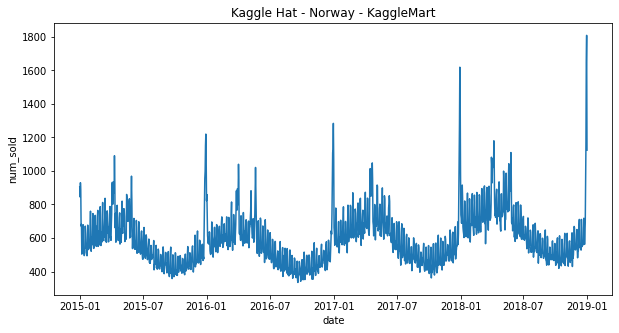

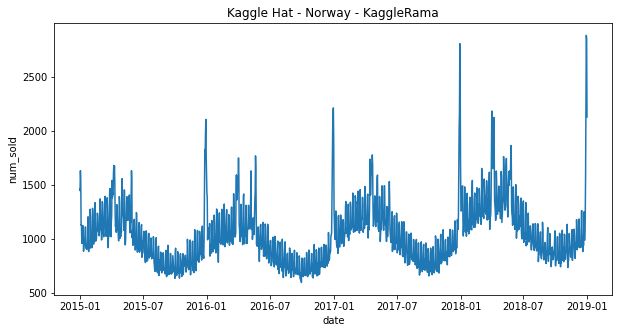

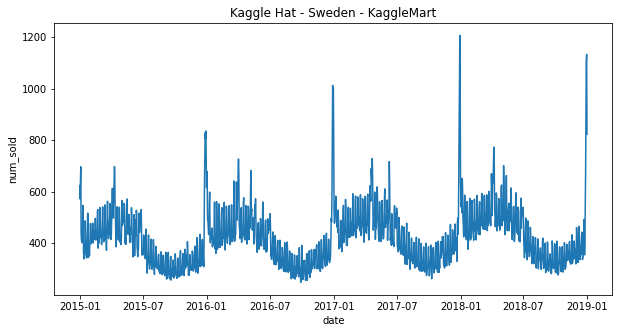

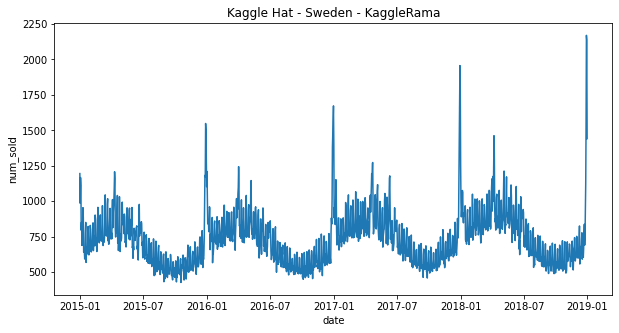

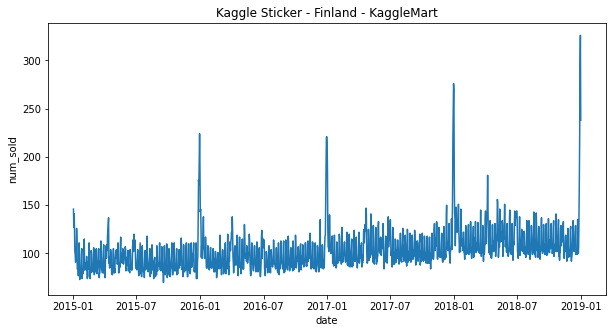

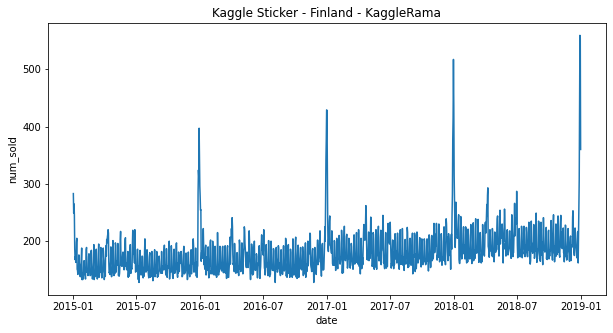

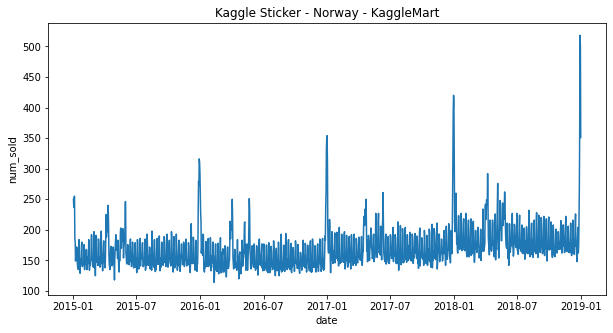

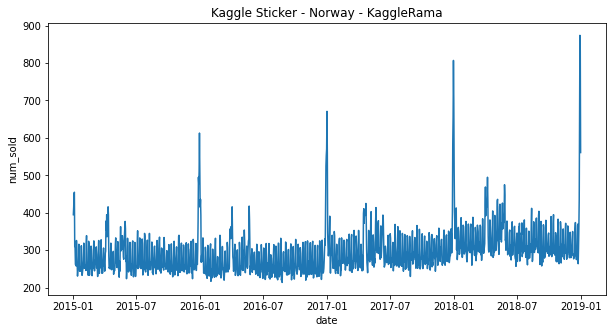

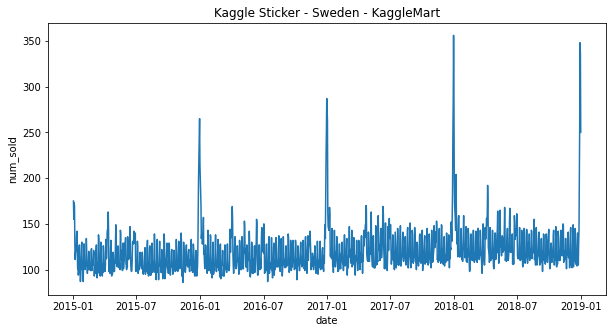

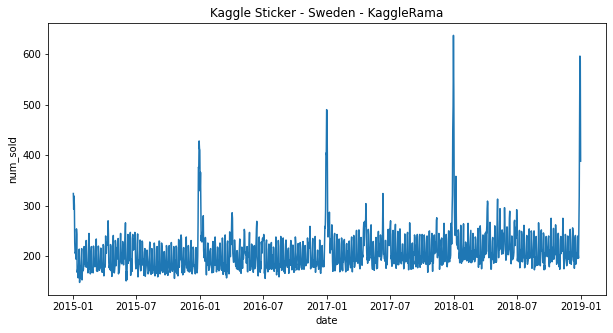

In [19]:
# Create a new dataframe with the relevant columns
df = train[['date','product','country','store','num_sold']]

# Iterate over the unique combinations of product, country, and store
for product in df['product'].unique():
    for country in df['country'].unique():
        for store in df['store'].unique():
            selection = (df['product']==product) & (df['country']==country) & (df['store']==store)
            selected = df[selection]
            
            # Create a line plot of the selected data
            plt.figure(figsize=(10, 5))
            sns.lineplot(x='date', y='num_sold', data=selected)
            plt.title(f"{product} - {country} - {store}")
            plt.show()


print(grid_search.best_params_)
print(grid_search.best_score_)# Modeling

In [20]:
train.store

0        KaggleMart
1        KaggleMart
2        KaggleMart
3        KaggleRama
4        KaggleRama
            ...    
26293    KaggleMart
26294    KaggleMart
26295    KaggleRama
26296    KaggleRama
26297    KaggleRama
Name: store, Length: 26298, dtype: object

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Create a list of categorical column names
categorical_cols = ['country', 'store', 'product']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(sparse=False), categorical_cols)
    ])

# Fit and transform the data
train_encoded = preprocessor.fit_transform(train)

train_encoded_df = pd.DataFrame(train_encoded, columns=preprocessor.named_transformers_['encoder'].get_feature_names(categorical_cols))

temp = [col for col in train.columns if col not in categorical_cols]
for col in temp:
    train_encoded_df[temp] = train[temp]

# train_encoded_df[['date','num_sold']] = train[['date','num_sold']]
train_encoded_df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


country_Finland  country_Norway  country_Sweden  store_KaggleMart  \
0              1.0             0.0             0.0               1.0   
1              1.0             0.0             0.0               1.0   
2              1.0             0.0             0.0               1.0   
3              1.0             0.0             0.0               0.0   
4              1.0             0.0             0.0               0.0   

   store_KaggleRama  product_Kaggle Hat  product_Kaggle Mug  \
0               0.0                 0.0                 1.0   
1               0.0                 1.0                 0.0   
2               0.0                 0.0                 0.0   
3               1.0                 0.0                 1.0   
4               1.0                 1.0                 0.0   

   product_Kaggle Sticker  row_id       date  num_sold  year  month  week  \
0                     0.0       0 2015-01-01       329  2015      1     1   
1                     0.0       1 2015-01-01       520  2015      1     1   
2                     1.0       2 2015-01-01       146  2015      1     1   
3                     0.0       3 2015-01-01       572  2015      1     1   
4                     0.0       4 2015-01-01       911  2015      1     1   

   day  dayofweek  quarter  dayofyear  
0    1          3        1          1  
1    1          3        1          1  
2    1          3        1          1  
3    1          3        1          1  
4    1          3        1          1

In [22]:
test_encoded = preprocessor.transform(test)

test_encoded_df = pd.DataFrame(test_encoded, columns=preprocessor.named_transformers_['encoder'].get_feature_names(categorical_cols))

temp = [col for col in test.columns if col not in categorical_cols]
for col in temp:
    test_encoded_df[col] = test[col]
test_encoded_df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


country_Finland  country_Norway  country_Sweden  store_KaggleMart  \
0              1.0             0.0             0.0               1.0   
1              1.0             0.0             0.0               1.0   
2              1.0             0.0             0.0               1.0   
3              1.0             0.0             0.0               0.0   
4              1.0             0.0             0.0               0.0   

   store_KaggleRama  product_Kaggle Hat  product_Kaggle Mug  \
0               0.0                 0.0                 1.0   
1               0.0                 1.0                 0.0   
2               0.0                 0.0                 0.0   
3               1.0                 0.0                 1.0   
4               1.0                 1.0                 0.0   

   product_Kaggle Sticker  row_id       date  year  month  week  day  \
0                     0.0   26298 2019-01-01  2019      1     1    1   
1                     0.0   26299 2019-01-01  2019      1     1    1   
2                     1.0   26300 2019-01-01  2019      1     1    1   
3                     0.0   26301 2019-01-01  2019      1     1    1   
4                     0.0   26302 2019-01-01  2019      1     1    1   

   dayofweek  quarter  dayofyear  
0          1        1          1  
1          1        1          1  
2          1        1          1  
3          1        1          1  
4          1        1          1

In [23]:
def SMAPE(y_true, y_pred):
    # From https://www.kaggle.com/cpmpml/smape-weirdness
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

def SMAPE_exp(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

def SMAPE_err(y_true, y_pred):
    # From https://www.kaggle.com/cpmpml/smape-weirdness
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return diff

In [24]:
train_encoded.shape

(26298, 8)

In [25]:
X_train = train_encoded_df[:len(train_encoded_df) - 6570]
X_val = train_encoded_df[len(train_encoded_df) - 6570:]


In [26]:
X_val.shape

(6570, 18)

In [27]:
y_train = X_train['num_sold']
X_train.drop(['num_sold','date','row_id'],axis=1, inplace=True)

y_val = X_val.loc[:,'num_sold']
X_val.drop(['num_sold','date','row_id'],axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_val)
print(f"mean_squared_error: {mean_squared_error(y_val, pred)}")
print(f"SMAPE: {SMAPE(y_true=y_val, y_pred=pred): 0.3f}")

mean_squared_error: 22057.149644151636
SMAPE:  27.288


In [29]:
multiplicative_model = reg.fit(X_train, np.log(y_train))
multiplicative_fit = np.exp(multiplicative_model.predict(X_val))
print(f"multiplicative fit: {SMAPE(y_true=y_val, y_pred=multiplicative_fit):0.3f}")

multiplicative fit: 13.005


In [30]:
train.head(1)

row_id       date  country       store     product  num_sold  year  month  \
0       0 2015-01-01  Finland  KaggleMart  Kaggle Mug       329  2015      1   

   week  day  dayofweek  quarter  dayofyear  
0     1    1          3        1          1

In [31]:
temp = train.iloc[len(train_encoded_df) - 6570:]
temp.loc[:,'pred'] = multiplicative_fit
temp.head(3)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


row_id       date  country       store         product  num_sold  year  \
19728   19728 2018-01-01  Finland  KaggleMart      Kaggle Mug       405  2018   
19729   19729 2018-01-01  Finland  KaggleMart      Kaggle Hat       621  2018   
19730   19730 2018-01-01  Finland  KaggleMart  Kaggle Sticker       176  2018   

       month  week  day  dayofweek  quarter  dayofyear        pred  
19728      1     1    1          0        1          1  187.413916  
19729      1     1    1          0        1          1  330.942004  
19730      1     1    1          0        1          1   95.655873

In [32]:
def graph_all(temp):    
    # Create a new dataframe with the relevant columns
    df = temp[['date','product','country','store','num_sold', 'pred']]

    # Iterate over the unique combinations of product, country, and store
    for product in df['product'].unique():
        for country in df['country'].unique():
            for store in df['store'].unique():
                selection = (df['product']==product) & (df['country']==country) & (df['store']==store)
                selected = df[selection]
                # Create a line plot of the selected data
                plt.figure(figsize=(10, 5))
                sns.lineplot(x='date', y='num_sold', data=selected)
                sns.lineplot(x='date',y='pred', data=selected)
                plt.title(f"{product} - {country} - {store}")
                plt.show()

In [33]:
import lightgbm as lgb
params = {'objective': 'regression', 
          'metric': 'mse', 
          'boosting_type': 'gbdt', 
          'learning_rate': 0.1, 
          'max_depth': 7, 
          'min_data_in_leaf': 100, 
          'num_leaves': 30}

train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_val,y_val)
# Train the model
model = lgb.train(params, train_data,
                  num_boost_round=500, valid_sets=[validation_data], 
                  early_stopping_rounds=100, verbose_eval=True);

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 19728, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 375.057786
[1]	valid_0's l2: 75321.4
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 64853.6
[3]	valid_0's l2: 56281.4
[4]	valid_0's l2: 49153.9
[5]	valid_0's l2: 43261.2
[6]	valid_0's l2: 38347.8
[7]	valid_0's l2: 34269.3
[8]	valid_0's l2: 30732.5
[9]	valid_0's l2: 27753.5
[10]	valid_0's l2: 25246.5
[11]	valid_0's l2: 22888.6
[12]	valid_0's l2: 20890.4
[13]	valid_0's l2: 19096.5
[14]	valid_0's l2: 17548.5

In [34]:
lgb_pred = model.predict(X_val)

In [35]:
lgb_temp = train.iloc[len(train_encoded_df) - 6570:]
lgb_temp.loc[:,'pred'] = lgb_pred
lgb_temp.head(3)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


row_id       date  country       store         product  num_sold  year  \
19728   19728 2018-01-01  Finland  KaggleMart      Kaggle Mug       405  2018   
19729   19729 2018-01-01  Finland  KaggleMart      Kaggle Hat       621  2018   
19730   19730 2018-01-01  Finland  KaggleMart  Kaggle Sticker       176  2018   

       month  week  day  dayofweek  quarter  dayofyear        pred  
19728      1     1    1          0        1          1  328.406983  
19729      1     1    1          0        1          1  488.700547  
19730      1     1    1          0        1          1  124.798531

In [36]:
def graph_all2(temp):
    # Create a new dataframe with the relevant columns
    df = temp[['date','product','country','store']]
    # Iterate over the unique combinations of product, country, and store
    for product in df['product'].unique():
        for country in df['country'].unique():
            for store in df['store'].unique():
                selection = (df['product']==product) & (df['country']==country) & (df['store']==store)
                selected = df[selection]
                # Check if num_sold or pred columns are present in the dataframe
                if 'num_sold' in temp.columns and 'pred' in temp.columns:
                    # If both columns are present, plot both lines
                    selected = selected.merge(temp[['date','product','country','store','num_sold', 'pred']], on=['date','product','country','store'], how='left')
                    plt.figure(figsize=(10, 5))
                    sns.lineplot(x='date', y='num_sold', data=selected)
                    sns.lineplot(x='date',y='pred', data=selected)
                elif 'num_sold' in temp.columns:
                    # If only num_sold column is present, plot only num_sold line
                    selected = selected.merge(temp[['date','product','country','store','num_sold']], on=['date','product','country','store'], how='left')
                    plt.figure(figsize=(10, 5))
                    sns.lineplot(x='date', y='num_sold', data=selected)
                elif 'pred' in temp.columns:
                    # If only pred column is present, plot only pred line
                    selected = selected.merge(temp[['date','product','country','store','pred']], on=['date','product','country','store'], how='left')
                    plt.figure(figsize=(10, 5))
                    sns.lineplot(x='date',y='pred', data=selected)
                else:
                    # If neither column is present, skip this iteration
                    continue
                # Set plot title and show the plot
                plt.title(f"{product} - {country} - {store}")
                plt.show()

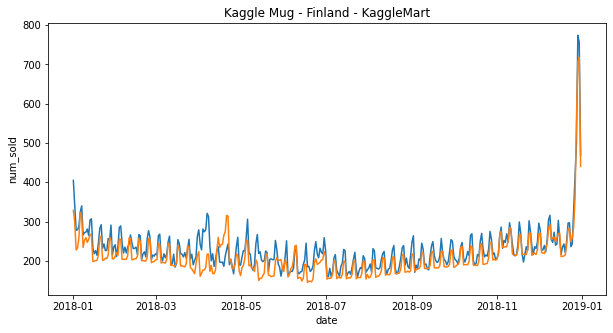

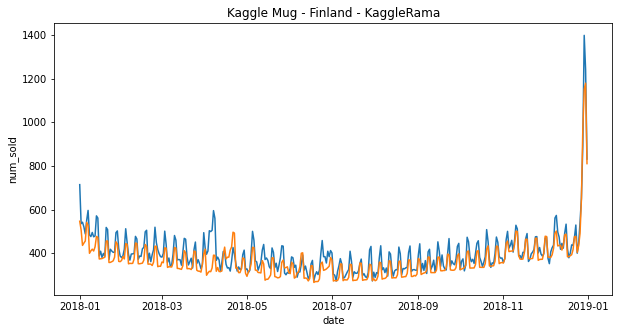

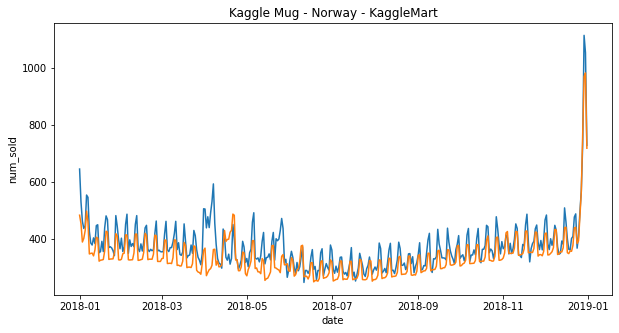

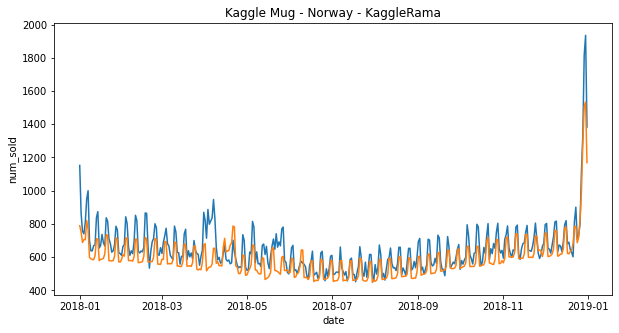

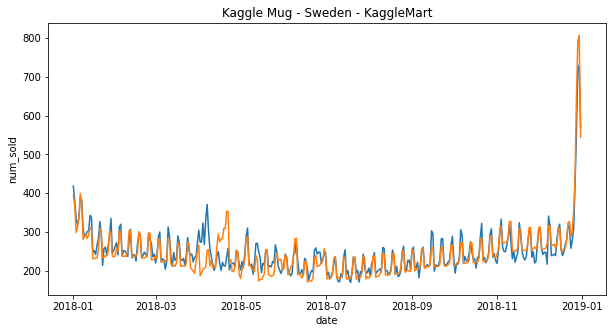

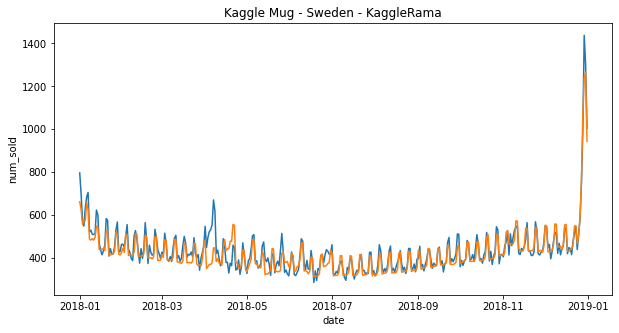

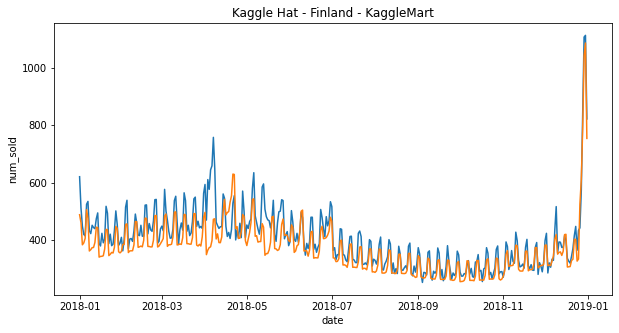

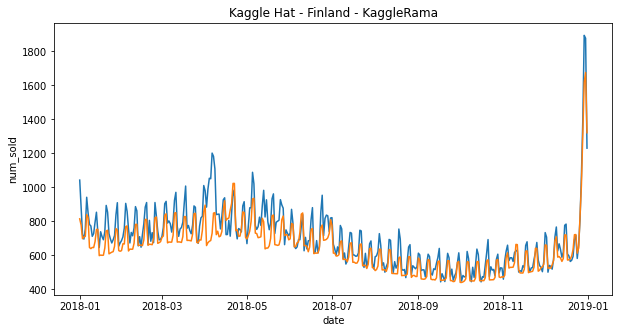

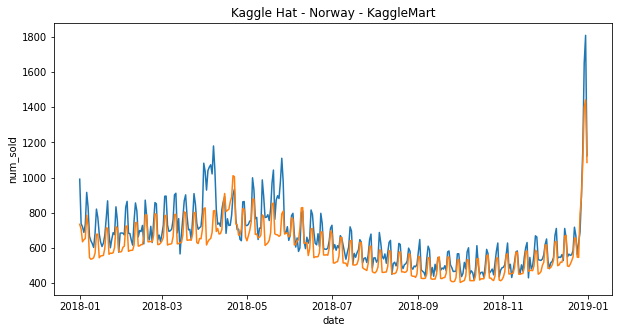

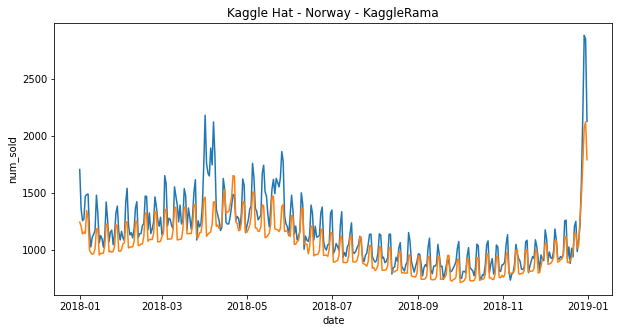

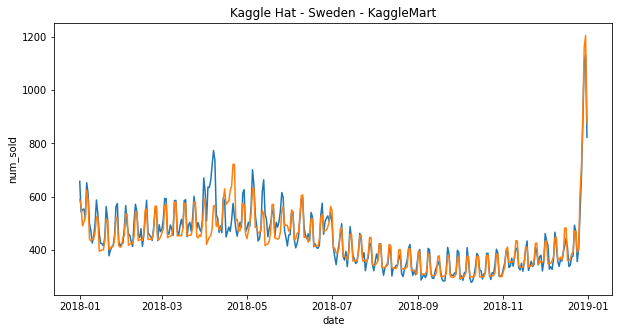

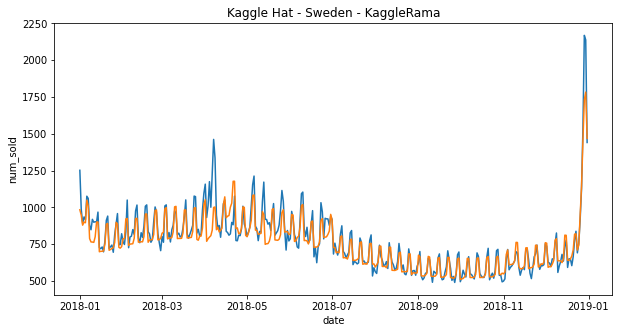

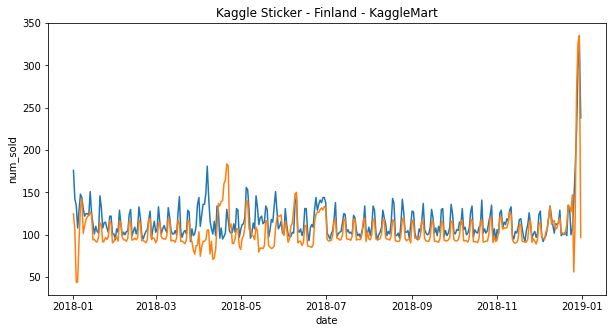

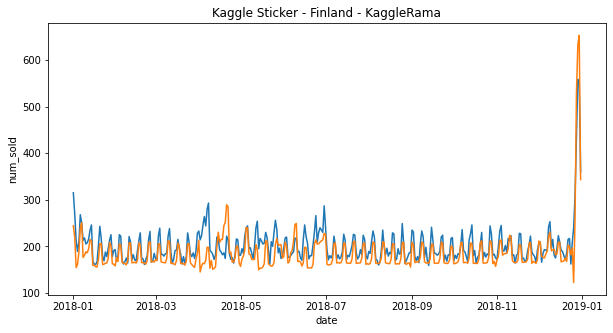

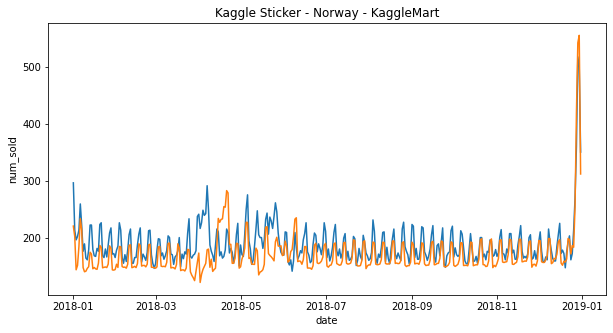

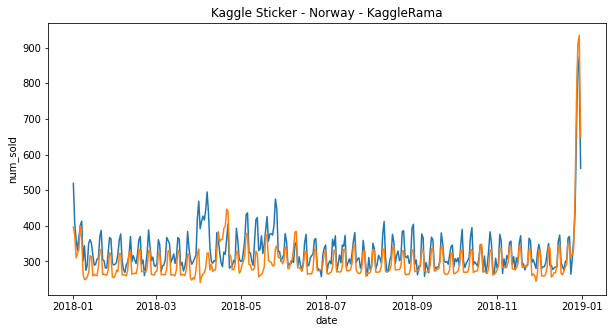

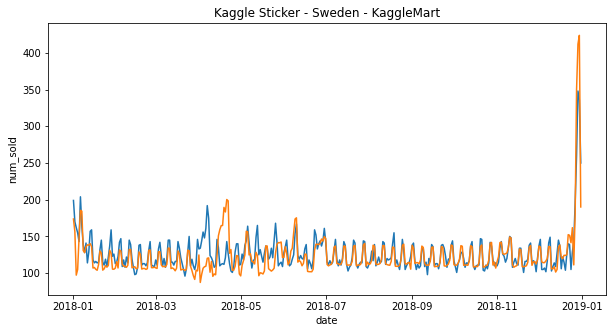

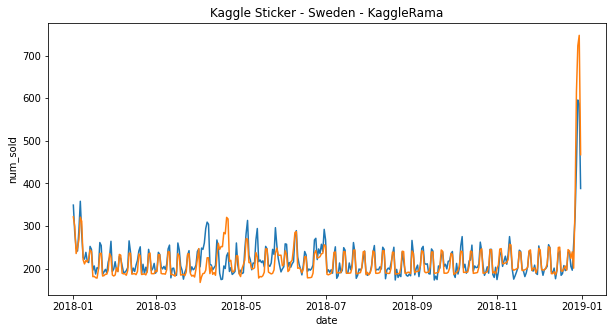

In [37]:
graph_all2(lgb_temp)

In [38]:
params = {'objective': 'regression', 
          'metric': 'mse', 
          'boosting_type': 'gbdt', 
          'learning_rate': 0.1, 
          'max_depth': 7, 
          'min_data_in_leaf': 100, 
          'num_leaves': 30}

# Train the model
model2 = lgb.LGBMRegressor(objective='regression', metric='rmse')
model2.fit(X_train, y_train)

LGBMRegressor(metric='rmse', objective='regression')

In [39]:
test_encoded_df

country_Finland  country_Norway  country_Sweden  store_KaggleMart  \
0                 1.0             0.0             0.0               1.0   
1                 1.0             0.0             0.0               1.0   
2                 1.0             0.0             0.0               1.0   
3                 1.0             0.0             0.0               0.0   
4                 1.0             0.0             0.0               0.0   
...               ...             ...             ...               ...   
6565              0.0             0.0             1.0               1.0   
6566              0.0             0.0             1.0               1.0   
6567              0.0             0.0             1.0               0.0   
6568              0.0             0.0             1.0               0.0   
6569              0.0             0.0             1.0               0.0   

      store_KaggleRama  product_Kaggle Hat  product_Kaggle Mug  \
0                  0.0                 0.0                 1.0   
1                  0.0                 1.0                 0.0   
2                  0.0                 0.0                 0.0   
3                  1.0                 0.0                 1.0   
4                  1.0                 1.0                 0.0   
...                ...                 ...                 ...   
6565               0.0                 1.0                 0.0   
6566               0.0                 0.0                 0.0   
6567               1.0                 0.0                 1.0   
6568               1.0                 1.0                 0.0   
6569               1.0                 0.0                 0.0   

      product_Kaggle Sticker  row_id       date  year  month  week  day  \
0                        0.0   26298 2019-01-01  2019      1     1    1   
1                        0.0   26299 2019-01-01  2019      1     1    1   
2                        1.0   26300 2019-01-01  2019      1     1    1   
3                        0.0   26301 2019-01-01  2019      1     1    1   
4                        0.0   26302 2019-01-01  2019      1     1    1   
...                      ...     ...        ...   ...    ...   ...  ...   
6565                     0.0   32863 2019-12-31  2019     12     1   31   
6566                     1.0   32864 2019-12-31  2019     12     1   31   
6567                     0.0   32865 2019-12-31  2019     12     1   31   
6568                     0.0   32866 2019-12-31  2019     12     1   31   
6569                     1.0   32867 2019-12-31  2019     12     1   31   

      dayofweek  quarter  dayofyear  
0             1        1          1  
1             1        1          1  
2             1        1          1  
3             1        1          1  
4             1        1          1  
...         ...      ...        ...  
6565          1        4        365  
6566          1        4        365  
6567          1        4        365  
6568          1        4        365  
6569          1        4        365  

[6570 rows x 17 columns]

In [40]:
train_pred = model.predict(train_encoded_df.drop(['date','num_sold','row_id'],axis=1))
train_with_pred = train.copy()
train_with_pred['pred'] = train_pred
train_with_pred

row_id       date  country       store         product  num_sold  year  \
0           0 2015-01-01  Finland  KaggleMart      Kaggle Mug       329  2015   
1           1 2015-01-01  Finland  KaggleMart      Kaggle Hat       520  2015   
2           2 2015-01-01  Finland  KaggleMart  Kaggle Sticker       146  2015   
3           3 2015-01-01  Finland  KaggleRama      Kaggle Mug       572  2015   
4           4 2015-01-01  Finland  KaggleRama      Kaggle Hat       911  2015   
...       ...        ...      ...         ...             ...       ...   ...   
26293   26293 2018-12-31   Sweden  KaggleMart      Kaggle Hat       823  2018   
26294   26294 2018-12-31   Sweden  KaggleMart  Kaggle Sticker       250  2018   
26295   26295 2018-12-31   Sweden  KaggleRama      Kaggle Mug      1004  2018   
26296   26296 2018-12-31   Sweden  KaggleRama      Kaggle Hat      1441  2018   
26297   26297 2018-12-31   Sweden  KaggleRama  Kaggle Sticker       388  2018   

       month  week  day  dayofweek  quarter  dayofyear         pred  
0          1     1    1          3        1          1   370.285994  
1          1     1    1          3        1          1   545.151167  
2          1     1    1          3        1          1   162.895091  
3          1     1    1          3        1          1   597.969559  
4          1     1    1          3        1          1   857.962160  
...      ...   ...  ...        ...      ...        ...          ...  
26293     12     1   31          0        4        365   875.927223  
26294     12     1   31          0        4        365   190.168609  
26295     12     1   31          0        4        365   944.007118  
26296     12     1   31          0        4        365  1468.804412  
26297     12     1   31          0        4        365   467.448657  

[26298 rows x 14 columns]

In [41]:
temp = test_encoded_df.drop(['date','row_id'],axis=1)
test_pred = model.predict(temp)
test_df = test.copy()
test_df['num_sold']=test_pred
submission = test_df.loc[:,['row_id','num_sold']]
#graph_all2(test_df)
#submission.to_csv('submission.csv', index=False)

In [42]:
to_graph = pd.concat([train_with_pred,test_df])

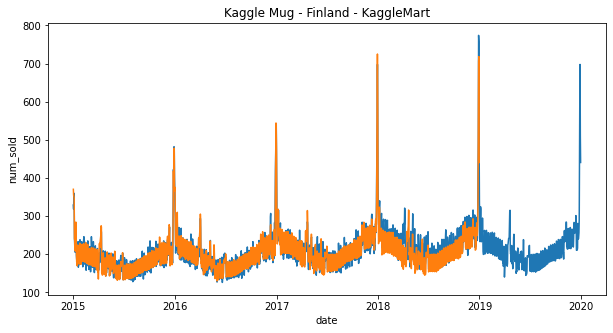

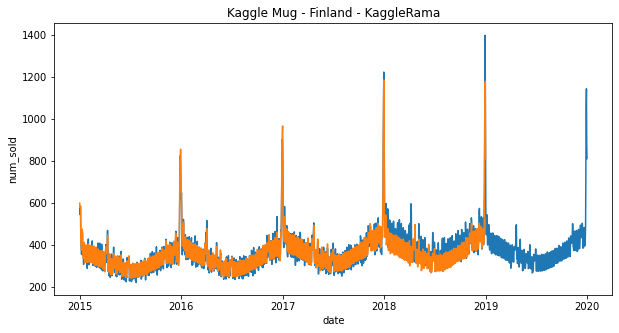

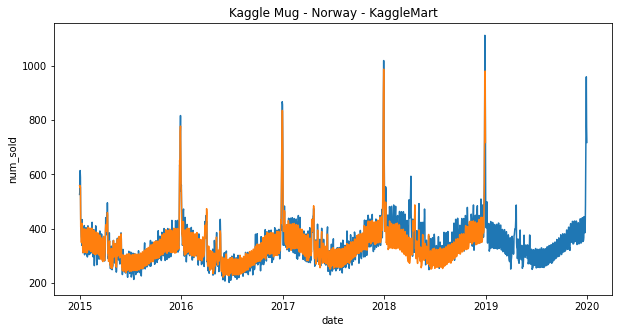

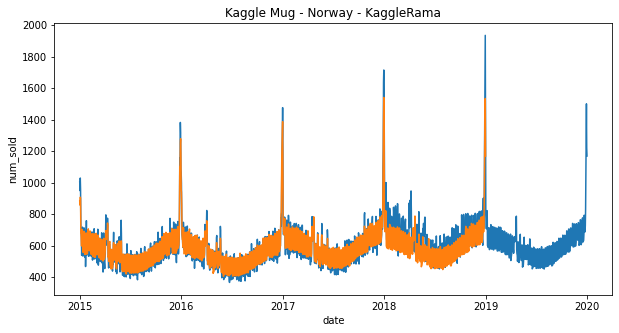

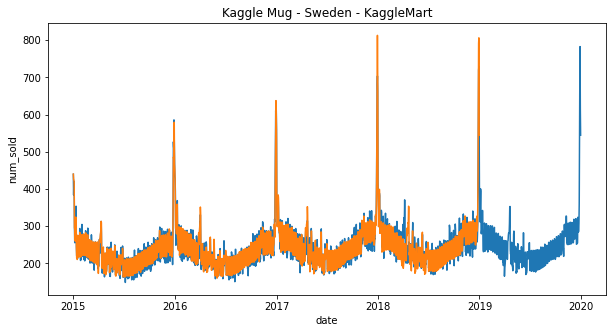

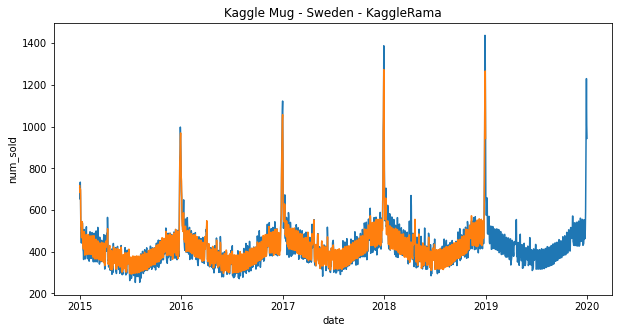

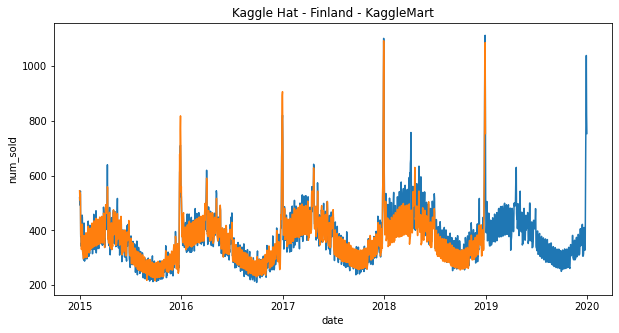

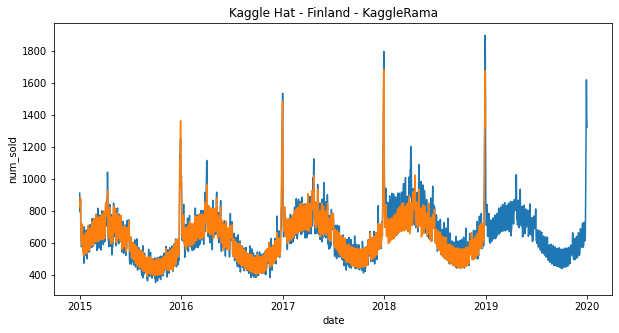

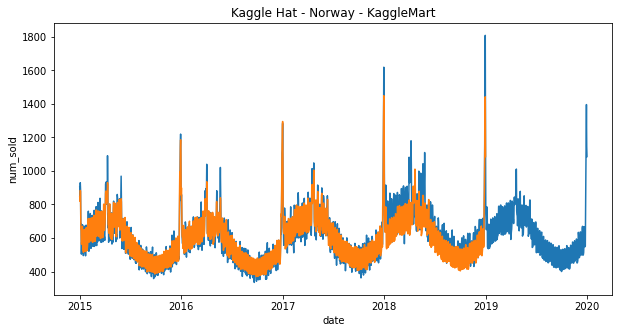

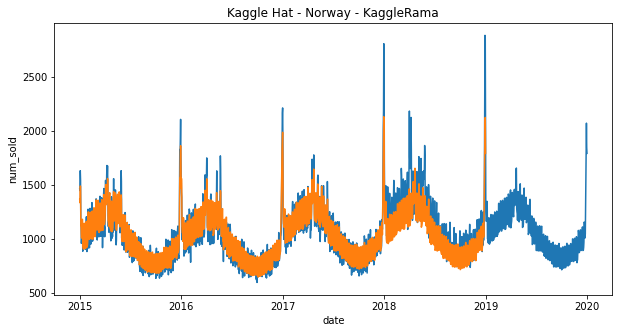

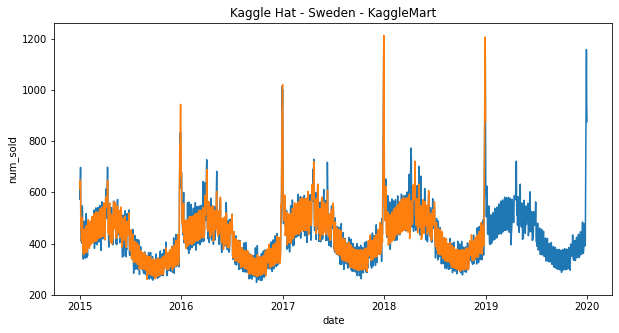

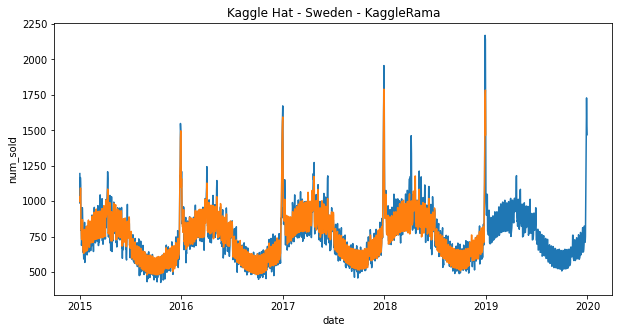

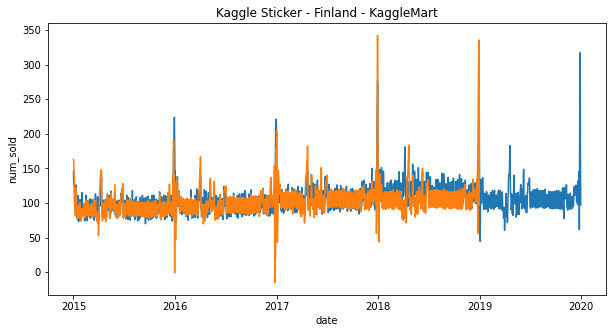

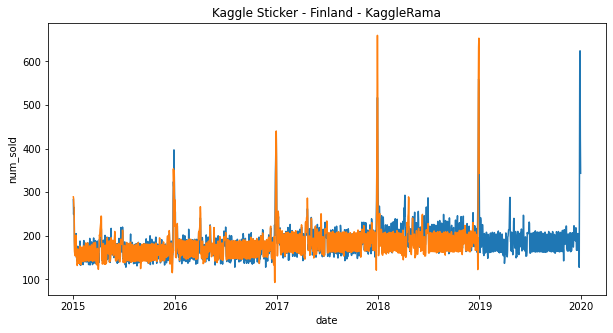

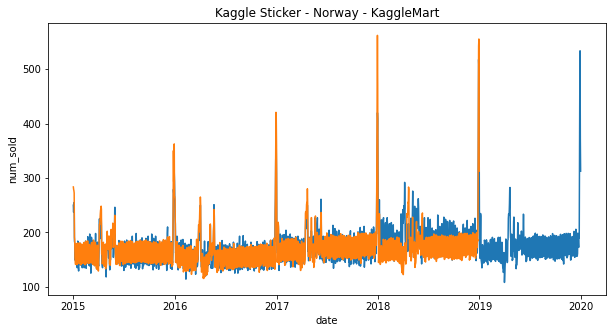

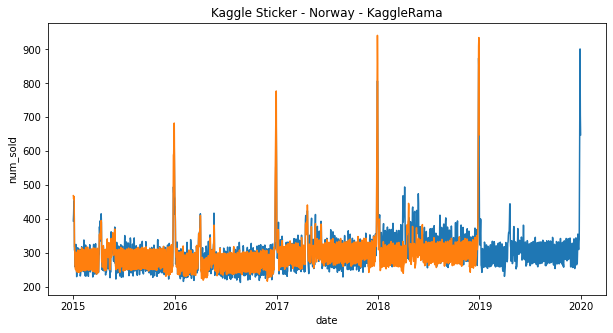

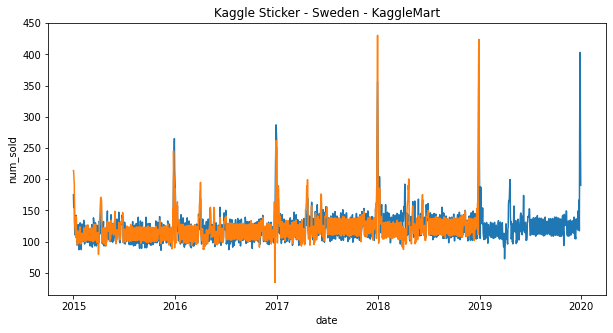

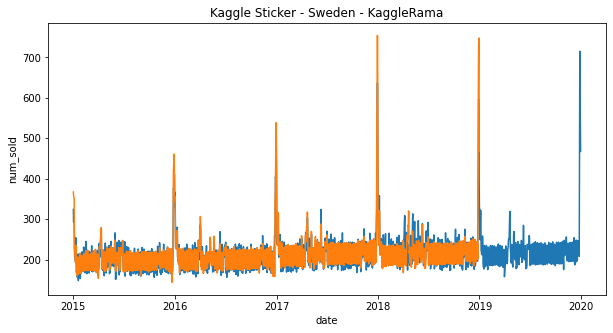

In [43]:
graph_all2(to_graph)

In [44]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Assume we have train and test datasets
X_train, y_train = train_encoded_df.drop(['row_id','date','num_sold'], axis=1), train_encoded_df['num_sold']

param_grid = {
    'num_leaves': [10, 20, 30], # the number of leaves in the tree
    'max_depth': [5, 10, -1], # the maximum depth of the tree, -1 means no limit
#     'min_child_samples': [20, 50, 100], # the minimum number of samples required to form a leaf node
#     'subsample': [0.5, 0.7, 1.0], # the fraction of rows to subsample at each iteration
    'learning_rate': [0.1], # the learning rate
    'n_estimators': [100, 200, 300], # the number of trees in the forest
#     'reg_alpha': [0.0, 0.1, 0.5], # L1 regularization term
     'reg_lambda': [0.0, 0.1, 0.5], # L2 regularization term
#     'min_split_gain': [0.0, 0.1, 0.5], # the minimum loss reduction required to make a split
    'objective': ['regression'], # the loss function to optimize
    'metric': ['rmse', 'mae'], # the evaluation metric to use
    'boosting_type': ['gbdt'], # the type of boosting algorithm to use
    'n_jobs': [-1] # the number of jobs to run in parallel (-1 means use all available CPUs)
}

# Create a LightGBM model
model = lgb.LGBMRegressor(objective='regression', metric='rmse')

# Define a time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define a grid search to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Use the best model to make predictions on the test data
best_model = grid_search.best_estimator_

Best hyperparameters:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'rmse', 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 20, 'objective': 'regression', 'reg_lambda': 0.1}
Best score:  -4535.688488107187


#Hyperparameter Search led to these

Best hyperparameters:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'rmse', 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'regression', 'reg_lambda': 0.1}
Best score:  -3743.0976461997348


In [45]:
temp_pred = best_model.predict(X_train)
temp_df = train.copy()
temp_df['pred'] = temp_pred
#graph_all(temp_df)

In [46]:
test_encoded_df.head()

country_Finland  country_Norway  country_Sweden  store_KaggleMart  \
0              1.0             0.0             0.0               1.0   
1              1.0             0.0             0.0               1.0   
2              1.0             0.0             0.0               1.0   
3              1.0             0.0             0.0               0.0   
4              1.0             0.0             0.0               0.0   

   store_KaggleRama  product_Kaggle Hat  product_Kaggle Mug  \
0               0.0                 0.0                 1.0   
1               0.0                 1.0                 0.0   
2               0.0                 0.0                 0.0   
3               1.0                 0.0                 1.0   
4               1.0                 1.0                 0.0   

   product_Kaggle Sticker  row_id       date  year  month  week  day  \
0                     0.0   26298 2019-01-01  2019      1     1    1   
1                     0.0   26299 2019-01-01  2019      1     1    1   
2                     1.0   26300 2019-01-01  2019      1     1    1   
3                     0.0   26301 2019-01-01  2019      1     1    1   
4                     0.0   26302 2019-01-01  2019      1     1    1   

   dayofweek  quarter  dayofyear  
0          1        1          1  
1          1        1          1  
2          1        1          1  
3          1        1          1  
4          1        1          1

In [47]:
temp_test_pred = best_model.predict(test_encoded_df.drop(['row_id','date'],axis=1))

In [48]:
test2 = test.copy()
test2['num_sold'] = temp_test_pred
submission2 = test2.loc[:,['row_id','num_sold']]
submission2

row_id     num_sold
0      26298   390.425802
1      26299   585.041600
2      26300   188.006548
3      26301   684.343920
4      26302   998.188117
...      ...          ...
6565   32863   835.966919
6566   32864   234.672474
6567   32865   989.663176
6568   32866  1490.138397
6569   32867   418.571415

[6570 rows x 2 columns]

In [49]:
best_submission = submission2.to_csv('submission.csv',index=False)

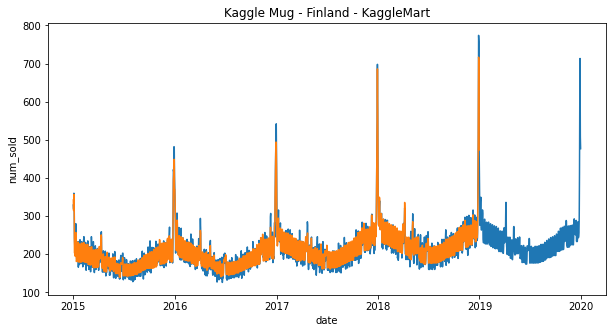

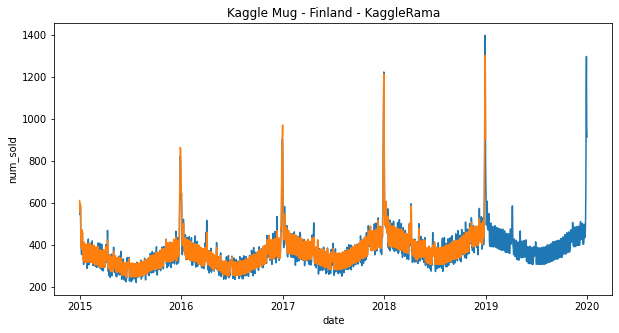

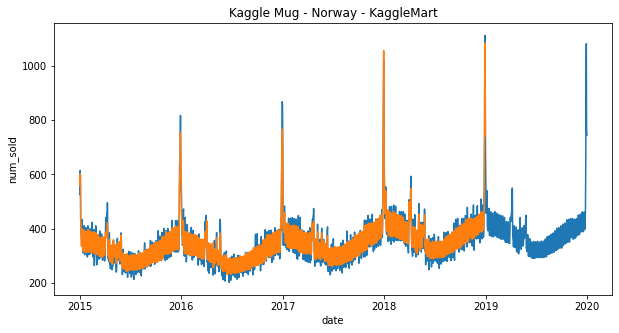

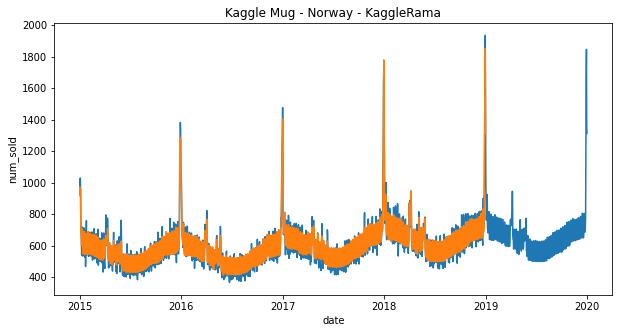

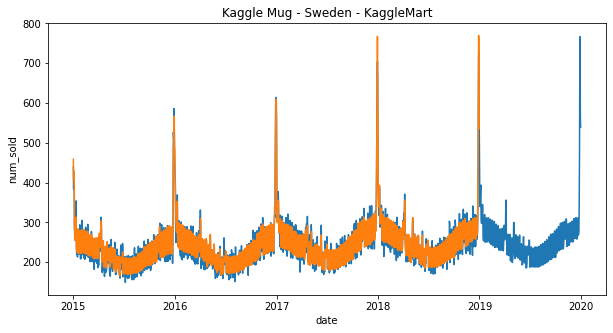

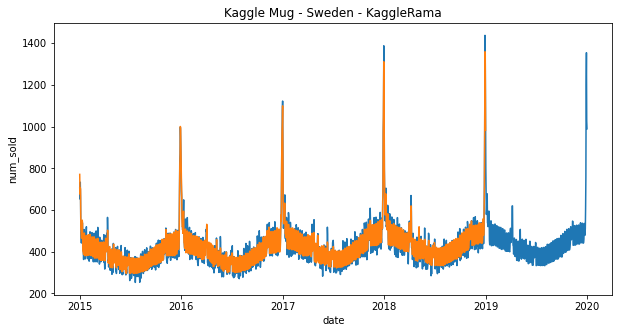

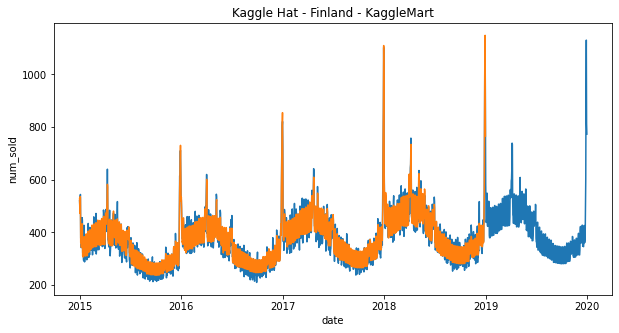

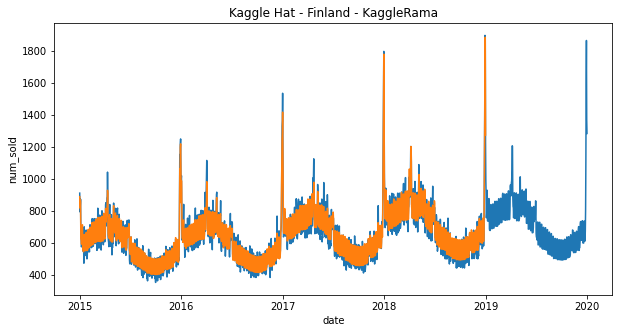

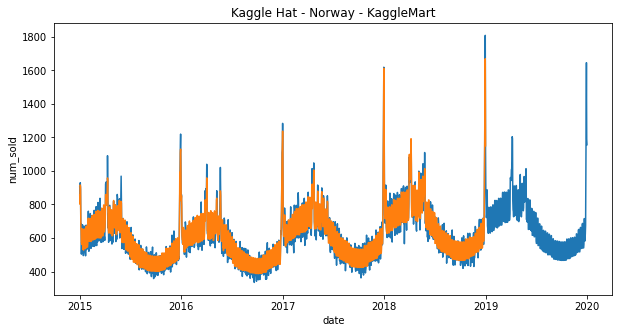

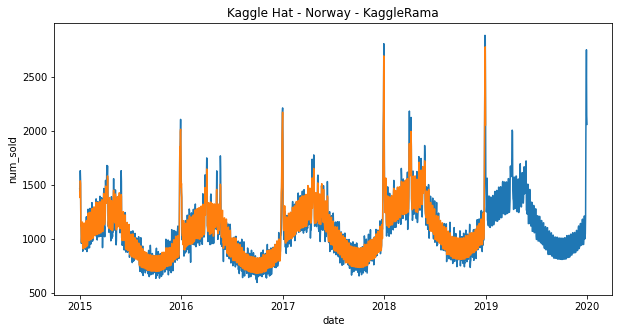

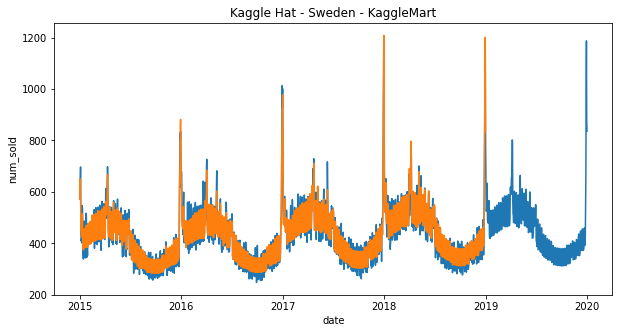

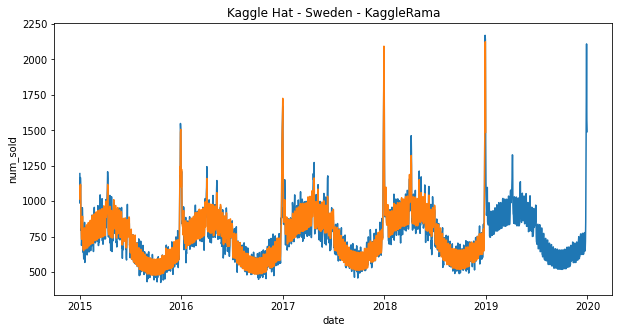

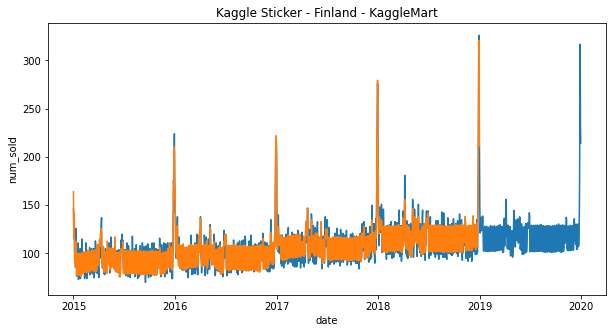

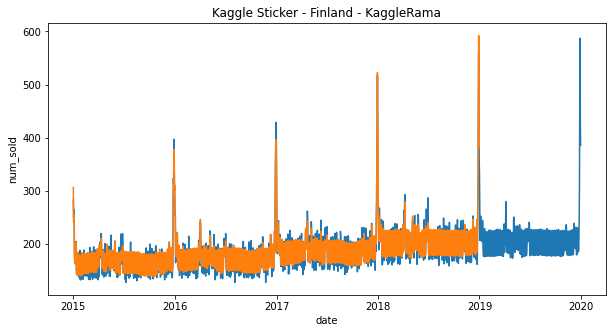

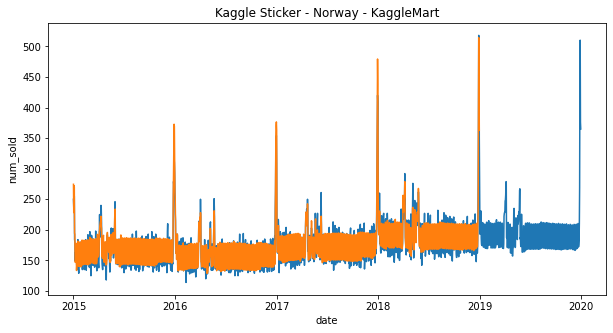

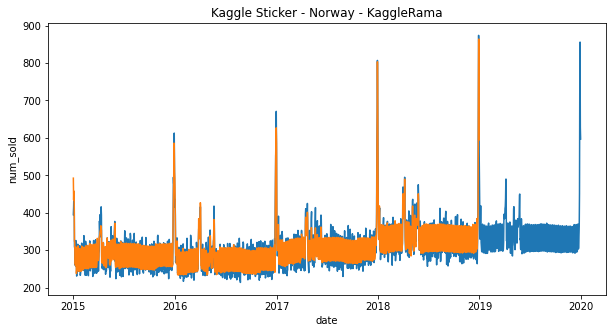

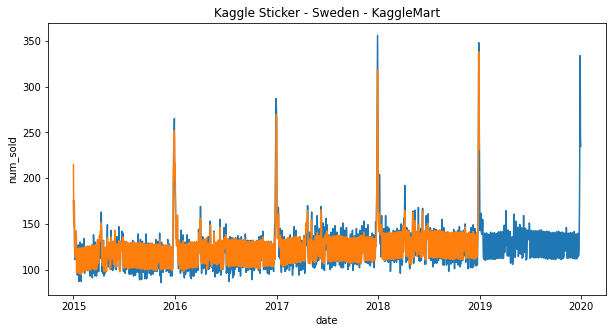

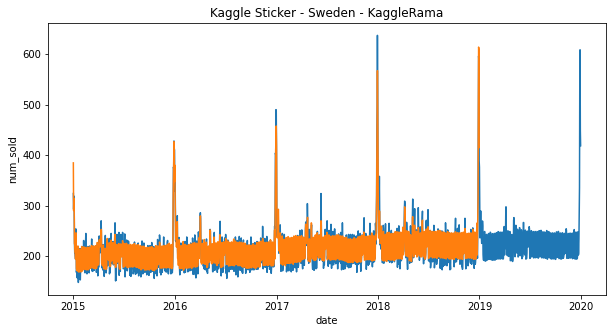

In [50]:
to_graph2 = pd.concat([temp_df,test2])
graph_all2(to_graph2)

## GridSearchCV experimentaion

In [51]:
# # Assume we have train and test datasets
# X_train, y_train = train_encoded_df.drop(['row_id','num_sold'], axis=1), train_encoded_df['num_sold']

# param_grid = {
#     'num_leaves': [30, 50, 100], # the number of leaves in the tree
#     'max_depth': [10], # the maximum depth of the tree, -1 means no limit
# #     'min_child_samples': [20, 50, 100], # the minimum number of samples required to form a leaf node
# #     'subsample': [0.5, 0.7, 1.0], # the fraction of rows to subsample at each iteration
#     'learning_rate': [0.1], # the learning rate
#     'n_estimators': [200], # the number of trees in the forest
# #     'reg_alpha': [0.0, 0.1, 0.5], # L1 regularization term
#      'reg_lambda': [0.0, 0.1], # L2 regularization term
# #     'min_split_gain': [0.0, 0.1, 0.5], # the minimum loss reduction required to make a split
#     'objective': ['regression'], # the loss function to optimize
#     'metric': ['rmse'], # the evaluation metric to use
#     'boosting_type': ['gbdt'], # the type of boosting algorithm to use
#     'n_jobs': [-1] # the number of jobs to run in parallel (-1 means use all available CPUs)
# }

# # Create a LightGBM model
# model = lgb.LGBMRegressor(objective='regression', metric='rmse')

# # Define a time series split for cross-validation
# tscv = TimeSeriesSplit(n_splits=5)

# # Define a grid search to find the best hyperparameters
# grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and best score
# print("Best hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# # Use the best model to make predictions on the test data
# best_model = grid_search.best_estimator_

# Future work

* Improve variable descriptions
* Improve comments for understanding
* Combine with other models to increase score